<a href="https://colab.research.google.com/github/narsym/Food-Images-101/blob/master/Food_Images_(Food_101)_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing kaggle to download the dataset

In [0]:
!pip install kaggle

Upload the json file

In [0]:
from google.colab import files
files.upload()

Preparation to download the file

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Download the dataset

In [0]:
!kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [01:50<00:00, 84.5MB/s]
100% 5.30G/5.30G [01:51<00:00, 51.3MB/s]


Unzip the data

In [0]:
!unzip food41.zip

Import necessary libraries

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, callbacks, models, utils 
import matplotlib.pyplot as plt
import PIL

Libraries for file system

In [0]:
import shutil
import os

As, there is no test split, Let's make a test directory

In [0]:
!mkdir test

Let's move 50 images from each folder in images directory to test directory.
Let's put images of respective classes in respective folders 

In [0]:
dirs = os.listdir('./images')
for i in dirs:
  img_names = os.listdir(os.path.join('./images/',i))
  src = os.path.join('./images',i)
  os.mkdir(os.path.join('./test',i))
  dest = os.path.join('./test',i)
  for j in img_names[:50]:
    shutil.move(os.path.join(src,j),os.path.join(dest,j))

As the number of images is huge, Let's use Keras ImageDataGenerator pipeline for efficiency to go easy on ram

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    './images',
    target_size = (160, 160),
    batch_size = 64, 
    class_mode = 'categorical',
    shuffle = True
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    './test',
    target_size = (160, 160),
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True
)

Found 95950 images belonging to 101 classes.
Found 5050 images belonging to 101 classes.


We know each class contains 1000 Images, so 101,000 images in total.

Let's visualize one image

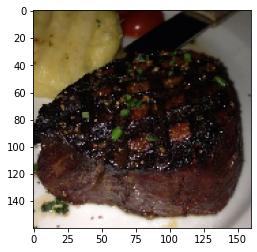

In [0]:
x, y = next(train_generator)
for i in x:
  plt.imshow(i)
  break

Let's use MObileNetV2 model for Transfer learning

In [0]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False,weights = 'imagenet')
base_model.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
________________

Add few layers after base model and make sequential model for training

In [0]:
model = tf.keras.Sequential([
     base_model,
     tf.keras.layers.GlobalAveragePooling2D(),
     tf.keras.layers.Dense(2048, activation = 'relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(1024, activation = 'relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(512),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(128, activation = 'relu'),
     tf.keras.layers.Dense(101,activation = 'softmax')
])

Callbacks and compilation

In [0]:
base_learning_rate = 0.0001
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 2, verbose = 1, min_lr = 0.00001)
mc = tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor = 'val_accuracy', save_best_only = True, verbose = True)
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

Training and Validation

In [0]:
initial_epochs = 5
history = model.fit(train_generator,epochs = initial_epochs, callbacks = [mc, lrr], validation_data = test_generator)

Epoch 1/5
1500/1500 [==============================] - ETA: 0s - loss: 3.4452 - accuracy: 0.2035
Epoch 00001: val_accuracy improved from -inf to 0.40931, saving model to ./best_model.h5
1500/1500 [==============================] - 610s 407ms/step - loss: 3.4452 - accuracy: 0.2035 - val_loss: 2.4508 - val_accuracy: 0.4093 - lr: 1.0000e-04
Epoch 2/5
1500/1500 [==============================] - ETA: 0s - loss: 2.5356 - accuracy: 0.3685
Epoch 00002: val_accuracy improved from 0.40931 to 0.46911, saving model to ./best_model.h5
1500/1500 [==============================] - 498s 332ms/step - loss: 2.5356 - accuracy: 0.3685 - val_loss: 2.1632 - val_accuracy: 0.4691 - lr: 1.0000e-04
Epoch 3/5
1500/1500 [==============================] - ETA: 0s - loss: 2.2752 - accuracy: 0.4293
Epoch 00003: val_accuracy improved from 0.46911 to 0.50079, saving model to ./best_model.h5
1500/1500 [==============================] - 478s 318ms/step - loss: 2.2752 - accuracy: 0.4293 - val_loss: 2.0338 - val_accuracy

Loading the best weights

In [0]:
model.load_weights('./best_model.h5')

Evaluating on the test set

In [0]:
model.evaluate(test_generator)

79/79 [==============================] - 25s 311ms/step - loss: 1.9070 - accuracy: 0.5273


[1.9069863557815552, 0.5273267030715942]

We got 52% accuracy. The model can be improved.